In [1]:
#Import the libaries

# Suppress warnings

import warnings
warnings.filterwarnings('ignore')

# Import 'numpy' and 'pandas' for working with numbers and data frames

import numpy as np
import pandas as pd

# Import 'pyplot' from 'matplotlib' and 'seaborn' for visualizations

from matplotlib import pyplot as plt
import seaborn as sns

# Import method for regression from 'statsmodels'
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import ProbPlot, qqplot

# import sklearn

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score

In [2]:
df = pd.read_csv("uber.csv" )

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [4]:
df.shape

(200000, 9)

In [5]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [6]:
df.dtypes

Unnamed: 0             int64
key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [7]:
# checking missing values
df.isnull().sum()


Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [8]:
df=df.dropna(how = 'any', axis=0)

In [9]:
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

filtering the DataFrame to ensure that the latitude and longitude values for both pickup and dropoff locations fall within valid geographical ranges.
Latitude values should be between -90 and 90. 
Longitude values should be between -180 and 180.

In [10]:
# removing dupicate
df.drop_duplicates(inplace=True)
df.shape

(199999, 9)

In [11]:
# Reframing the columns

df = df[(df.pickup_latitude<90) & (df.dropoff_latitude<90) &
        (df.pickup_latitude>-90) & (df.dropoff_latitude>-90) &
        (df.pickup_longitude<180) & (df.dropoff_longitude<180) &
        (df.pickup_longitude>-180) & (df.dropoff_longitude>-180)]

In [12]:
# Convert 'pickup_datetime' to datetime
df.pickup_datetime=pd.to_datetime(df.pickup_datetime)

In [13]:
df['pickup_datetime'] 

0        2015-05-07 19:52:06+00:00
1        2009-07-17 20:04:56+00:00
2        2009-08-24 21:45:00+00:00
3        2009-06-26 08:22:21+00:00
4        2014-08-28 17:47:00+00:00
                    ...           
199995   2012-10-28 10:49:00+00:00
199996   2014-03-14 01:09:00+00:00
199997   2009-06-29 00:42:00+00:00
199998   2015-05-20 14:56:25+00:00
199999   2010-05-15 04:08:00+00:00
Name: pickup_datetime, Length: 199987, dtype: datetime64[ns, UTC]

In [14]:
# Extract useful features from 'pickup_datetime'
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek

In [15]:
df.shape

(199987, 13)

now I want to analysis different behaviors due to weather, holidays, or other seasonal factors,like ride demand and how ride demand, pricing, and other factors change throughout the day. 
This can help identify peak hours, off-peak hours, and other time-related patterns.

In [16]:
df['Monthly_Quarter'] = df.pickup_month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',
                                      8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'})
df['Hourly_Segments'] = df.pickup_hour.map({0:'H1',1:'H1',2:'H1',3:'H1',4:'H2',5:'H2',6:'H2',7:'H2',8:'H3',
                                     9:'H3',10:'H3',11:'H3',12:'H4',13:'H4',14:'H4',15:'H4',16:'H5',
                                     17:'H5',18:'H5',19:'H5',20:'H6',21:'H6',22:'H6',23:'H6'})

In [17]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_day,pickup_month,pickup_day_of_week,Monthly_Quarter,Hourly_Segments
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,3,Q2,H5
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7,4,Q3,H6
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8,0,Q3,H6
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,26,6,4,Q2,H3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,28,8,3,Q3,H5


In [18]:
df.shape

(199987, 15)

We extract time-based features from the pickup_datetime column and compute the distance between pickup and dropoff points using the Haversine formula.

In [19]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Calculate the great circle distance between two points 
    # on the earth (specified in decimal degrees)
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r
df['distance'] = df.apply(lambda row: haversine_distance(
 row['pickup_latitude'], row['pickup_longitude'],
 row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

In [20]:
df.drop(['pickup_datetime','pickup_month', 'pickup_hour',], axis=1, inplace=True)


In [21]:
df.shape

(199987, 13)

In [22]:
df.drop(['Unnamed: 0','key'], axis=1, inplace=True)

In [23]:
df.shape

(199987, 11)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199987 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fare_amount         199987 non-null  float64
 1   pickup_longitude    199987 non-null  float64
 2   pickup_latitude     199987 non-null  float64
 3   dropoff_longitude   199987 non-null  float64
 4   dropoff_latitude    199987 non-null  float64
 5   passenger_count     199987 non-null  int64  
 6   pickup_day          199987 non-null  int64  
 7   pickup_day_of_week  199987 non-null  int64  
 8   Monthly_Quarter     199987 non-null  object 
 9   Hourly_Segments     199987 non-null  object 
 10  distance            199987 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 18.3+ MB


In [25]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_day_of_week,Monthly_Quarter,Hourly_Segments,distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,7,3,Q2,H5,1.683323
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,17,4,Q3,H6,2.457590
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,24,0,Q3,H6,5.036377
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,26,4,Q2,H3,1.661683
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,28,3,Q3,H5,4.475450


In [26]:
#Checking number of unique rows 
df.nunique().sort_values()

Monthly_Quarter            4
Hourly_Segments            6
pickup_day_of_week         7
passenger_count            8
pickup_day                31
fare_amount             1244
pickup_longitude       71055
dropoff_longitude      76890
pickup_latitude        83831
dropoff_latitude       90582
distance              194348
dtype: int64

now divided the dataset into numerical features and categorical wher features 24 or fewer unique values are considered categorical, and the rest are considered numerical.

In [27]:
# create a list of features from the DataFrame df, excluding the target variable fare_amount
target = 'fare_amount'
features = [i for i in df.columns if i not in [target]]

In [28]:
nu = df.drop([target], axis=1).nunique().sort_values()

In [29]:
# Initialize lists for numerical(nf )and categorical features(cf)
cf = ['Monthly_Quarter', 'Hourly_Segments', 'pickup_day_of_week', 'passenger_count', 'pickup_day']  
nf = ['fare_amount', 'pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude', 'distance']  

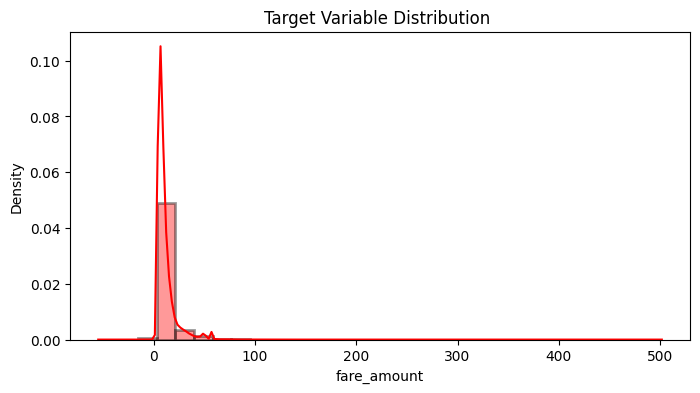

In [30]:
plt.figure(figsize=[8,4])
sns.distplot(df[target], color='r',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution ')
plt.show()

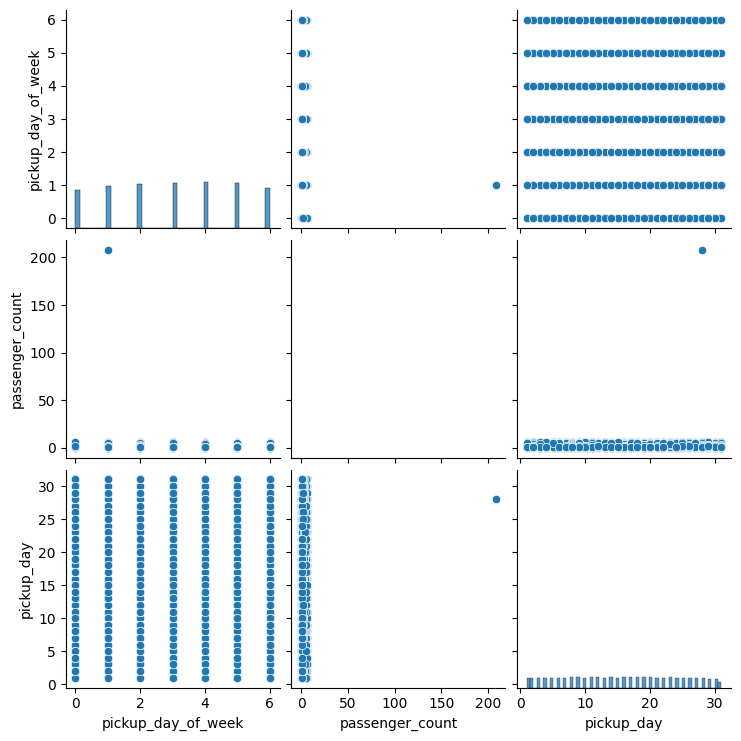

In [31]:
sns.pairplot(df[cf])
plt.show()

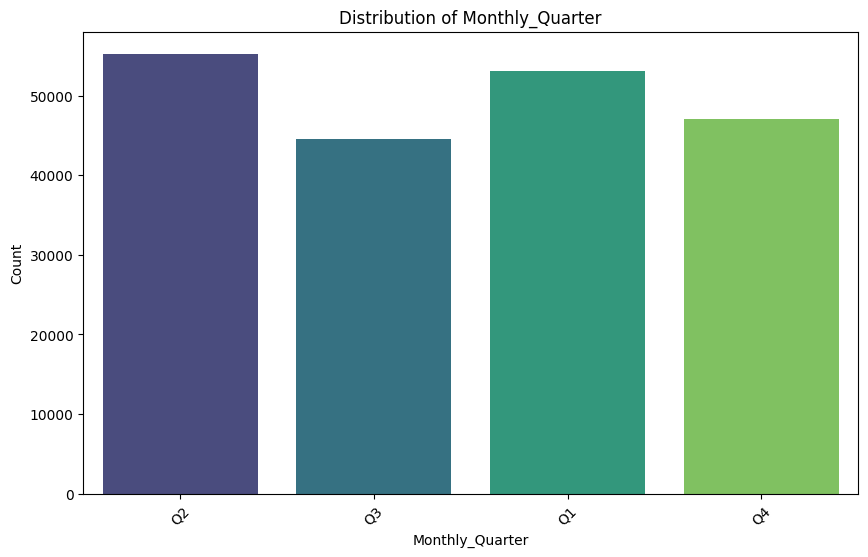

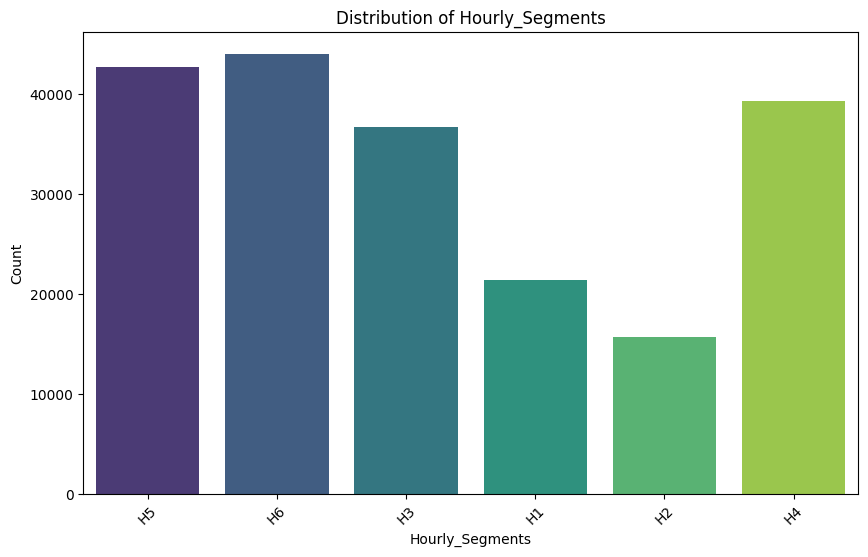

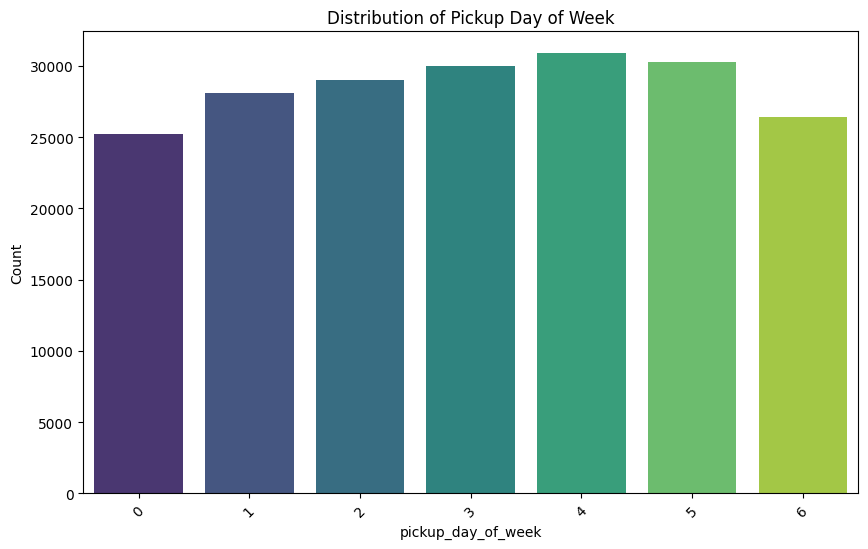

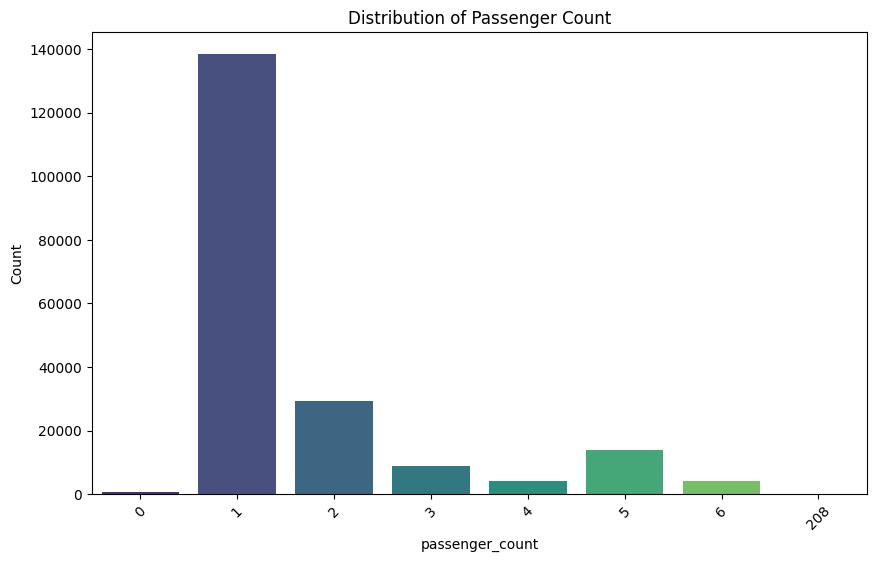

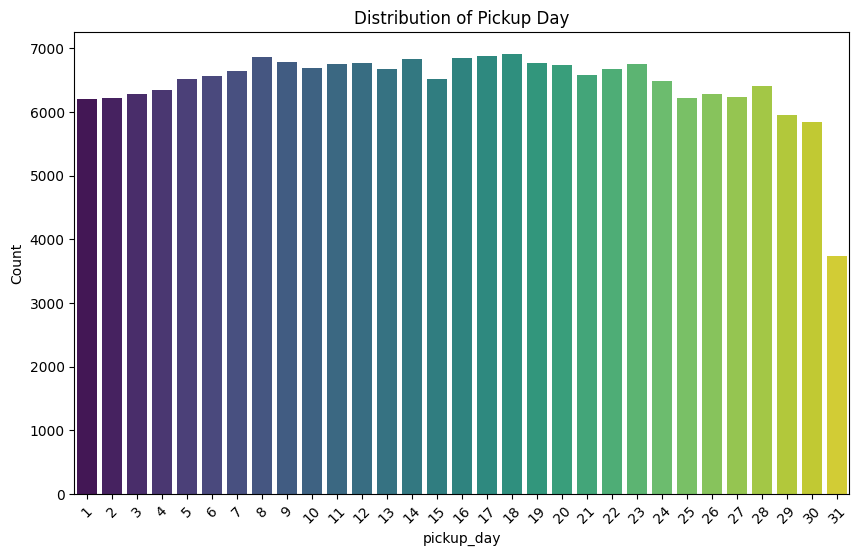

In [32]:
if 'Monthly_Quarter' in cf:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='Monthly_Quarter', palette='viridis')
    plt.title('Distribution of Monthly_Quarter')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.show()

if 'Hourly_Segments' in cf:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='Hourly_Segments', palette='viridis')
    plt.title('Distribution of Hourly_Segments')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.show()

if 'pickup_day_of_week' in cf:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='pickup_day_of_week', palette='viridis')
    plt.title('Distribution of Pickup Day of Week')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.show()

if 'passenger_count' in cf:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='passenger_count', palette='viridis')
    plt.title('Distribution of Passenger Count')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.show()

if 'pickup_day' in cf:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='pickup_day', palette='viridis')
    plt.title('Distribution of Pickup Day')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.show()

In [33]:
passenger_fare_totals = df.groupby('passenger_count')['fare_amount'].sum().reset_index()
passenger_fare_totals.columns = ['passenger_count', 'total_fare_amount']
passenger_fare_totals

,passenger_count,total_fare_amount
0,0,6683.00
1,1,1557745.56
2,2,346777.14
3,3,102013.66
4,4,49769.51
5,5,156892.47
6,6,51929.11
7,208,11.70


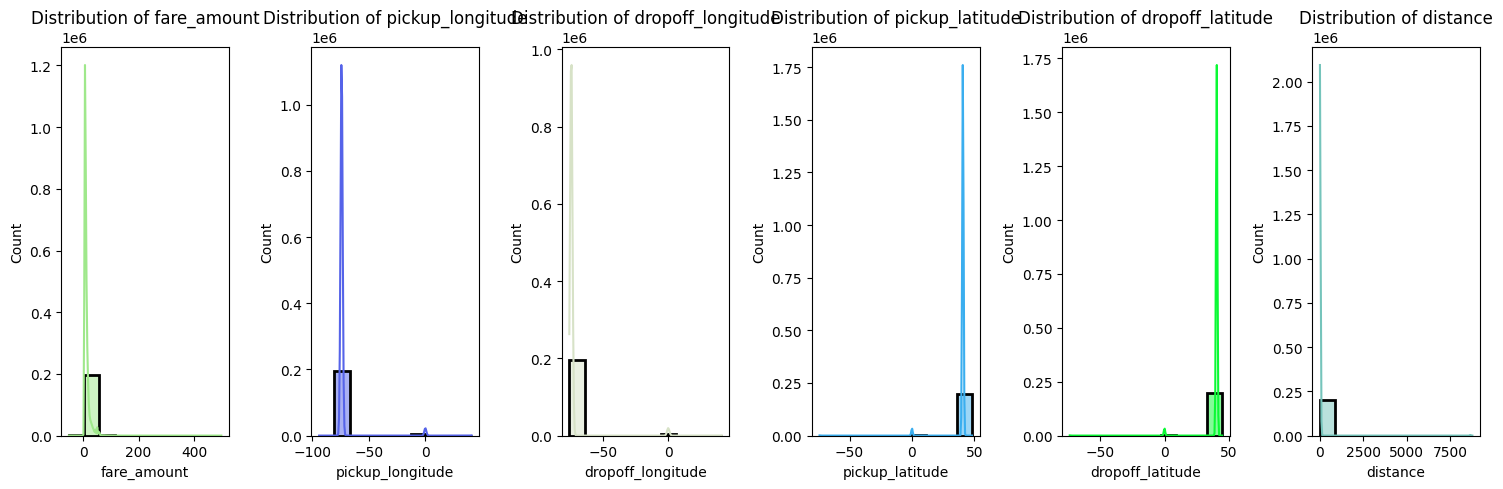

In [34]:
import math
n=6
plt.figure(figsize=[15, 5 * math.ceil(len(nf) / n)])
for i, feature in enumerate(nf):
    plt.subplot(math.ceil(len(nf) / n), n, i + 1)
    sns.histplot(df[feature], bins=10, kde=True, color=np.random.rand(3,), edgecolor="black", linewidth=2)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


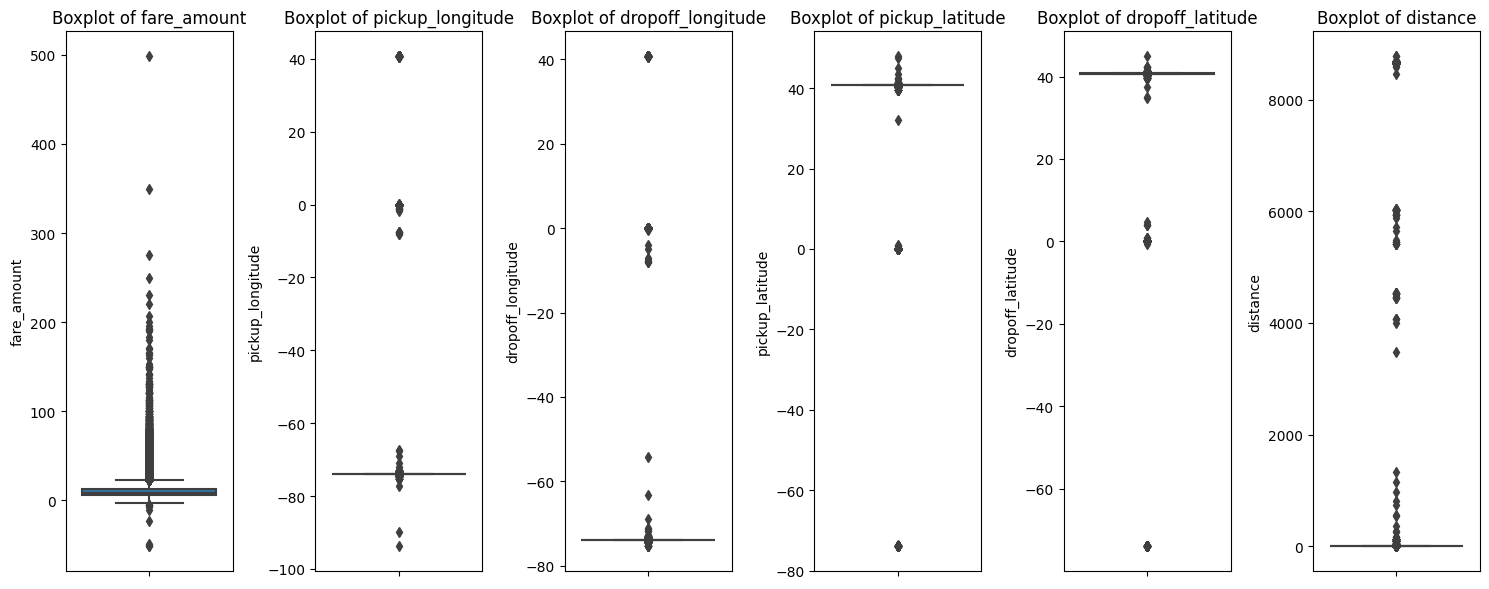

In [35]:
import math
n=6
plt.figure(figsize=[15, 6 * math.ceil(len(nf) / n)])
for i, feature in enumerate(nf):
    plt.subplot(math.ceil(len(nf) / n), n, i + 1)
    sns.boxplot(y=df[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

In [36]:
df. shape

(199987, 11)

In [37]:
df.drop_duplicates(inplace=True)
df.shape

(199967, 11)

In [38]:
df.drop(['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'],axis=1)


,fare_amount,passenger_count,pickup_day,pickup_day_of_week,Monthly_Quarter,Hourly_Segments,distance
0,7.5,1,7,3,Q2,H5,1.683323
1,7.7,1,17,4,Q3,H6,2.457590
2,12.9,1,24,0,Q3,H6,5.036377
3,5.3,3,26,4,Q2,H3,1.661683
4,16.0,5,28,3,Q3,H5,4.475450
...,...,...,...,...,...,...,...
199995,3.0,1,28,6,Q4,H3,0.112210
199996,7.5,1,14,4,Q1,H1,1.875050
199997,30.9,2,29,0,Q2,H1,12.850319
199998,14.5,1,20,2,Q2,H4,3.539715


In [39]:
df.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_day', 'pickup_day_of_week', 'Monthly_Quarter',
       'Hourly_Segments', 'distance'],
      dtype='object')

In [40]:
##Converting categorical Columns to Numeric
df1 = df.copy()
df3 = df1.copy()

In [41]:
# ecc is defined as the index values of rows where all values are not equal to 0.
#fcc is defined as the list of columns in cf that are not in ecc.
ecc = df[df != 0].index.values
fcc = [i for i in cf if i not in ecc]

In [42]:
# Identify columns with exactly two unique values for one-hot encoding
binary_cols = [i for i in fcc if df3[i].nunique() == 2]

# Identify columns with more than two but fewer than 17 unique values for dummy encoding
dummy_cols = [i for i in fcc if 2 < df3[i].nunique() < 17]

# Apply one-hot encoding for binary columns
df3[binary_cols] = df3[binary_cols].apply(lambda x: pd.get_dummies(x, drop_first=True, prefix=x.name))

# Apply dummy encoding for columns with more than two but fewer than 17 unique values
df3 = pd.get_dummies(df3, columns=dummy_cols, drop_first=True, prefix=dummy_cols)

df3.shape

(199967, 28)

In [43]:
# Encode categorical features
df = pd.get_dummies(df, drop_first=True)

# Handle missing values by dropping rows with any missing values
df = df.dropna(how='any', axis=0)

In [44]:
# Remove outliers using IQR method
def remove_outliers_iqr(df, numerical_features):
    for feature in numerical_features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df


In [45]:
df = remove_outliers_iqr(df, nf)

In [46]:
df.shape

(160191, 17)

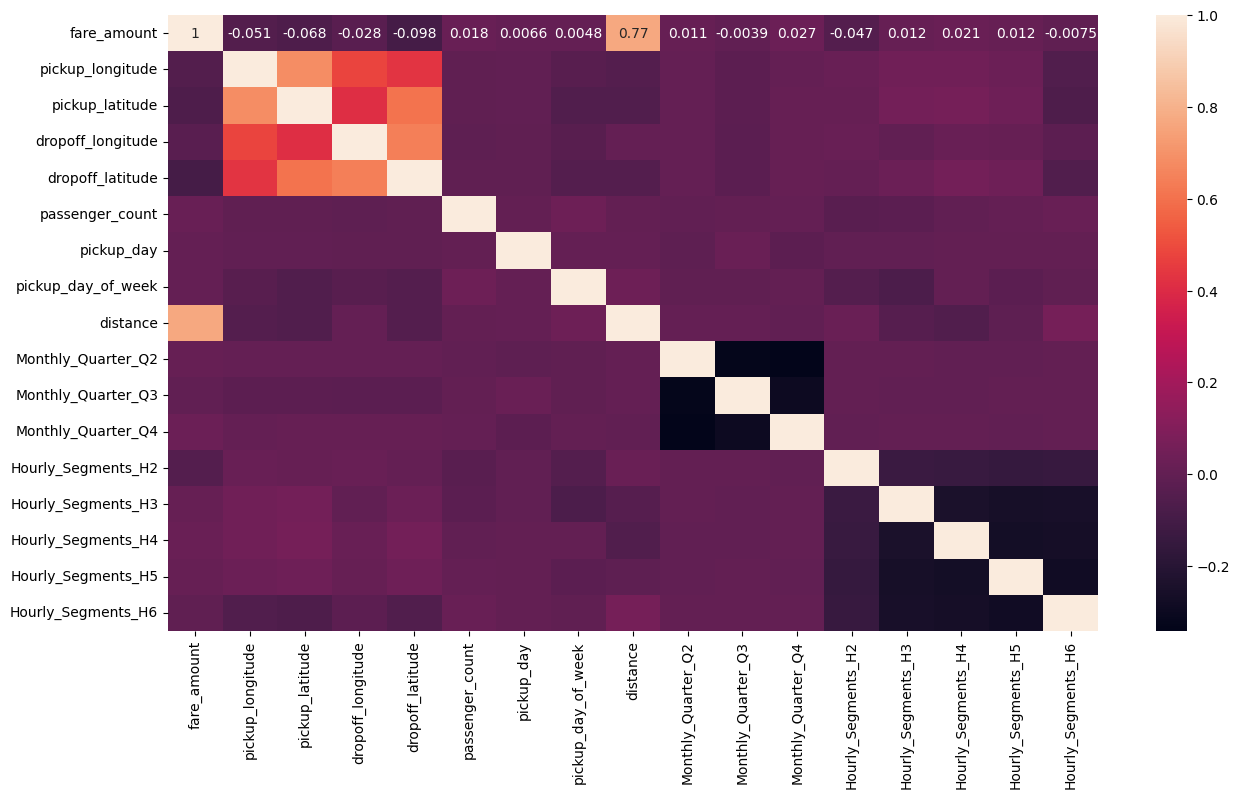

In [47]:
plt.figure(figsize=[15,8])
sns.heatmap(df.corr(), annot=True)
plt.show()

In [48]:
# model building

In [49]:
X = df.drop([target],axis=1)
Y = df[target]

In [50]:
# split the data set
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size= 0.70, random_state= 100)

In [51]:
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_day_of_week,distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,Hourly_Segments_H3,Hourly_Segments_H4,Hourly_Segments_H5,Hourly_Segments_H6
173457,-73.978450,40.757557,-73.955302,40.773457,1,23,0,2.631779,1,0,0,0,0,0,1,0
89798,-73.969698,40.752801,-73.971843,40.765639,1,17,5,1.438907,1,0,0,0,1,0,0,0
147828,-73.973833,40.764202,-73.978765,40.756392,2,17,1,0.962667,0,0,1,0,0,0,1,0
78528,-73.986961,40.725605,-74.000565,40.724838,1,3,2,1.149492,1,0,0,0,1,0,0,0
81950,-73.982528,40.768193,-73.998676,40.761169,1,1,4,1.568285,0,0,1,0,0,1,0,0


In [52]:
X_train.dtypes

pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
passenger_count         int64
pickup_day              int64
pickup_day_of_week      int64
distance              float64
Monthly_Quarter_Q2      uint8
Monthly_Quarter_Q3      uint8
Monthly_Quarter_Q4      uint8
Hourly_Segments_H2      uint8
Hourly_Segments_H3      uint8
Hourly_Segments_H4      uint8
Hourly_Segments_H5      uint8
Hourly_Segments_H6      uint8
dtype: object

In [53]:
X_train.reset_index(drop=True,inplace=True)

In [54]:
X_test.dtypes

pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
passenger_count         int64
pickup_day              int64
pickup_day_of_week      int64
distance              float64
Monthly_Quarter_Q2      uint8
Monthly_Quarter_Q3      uint8
Monthly_Quarter_Q4      uint8
Hourly_Segments_H2      uint8
Hourly_Segments_H3      uint8
Hourly_Segments_H4      uint8
Hourly_Segments_H5      uint8
Hourly_Segments_H6      uint8
dtype: object

In [55]:
X_test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_day_of_week,distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,Hourly_Segments_H3,Hourly_Segments_H4,Hourly_Segments_H5,Hourly_Segments_H6
126710,-73.966336,40.794469,-73.985170,40.779074,2,24,3,2.333388,0,0,0,0,0,1,0,0
172333,-73.981057,40.764015,-73.982127,40.767478,3,3,6,0.395471,0,0,0,0,0,1,0,0
140669,-73.974463,40.760630,-73.987007,40.776045,1,9,2,2.013449,0,0,0,0,0,0,0,1
143373,-73.987223,40.776076,-73.948413,40.774788,2,1,0,3.271139,0,0,1,0,1,0,0,0
42087,-74.000102,40.761207,-73.991612,40.751532,1,23,3,1.291800,0,0,1,1,0,0,0,0


In [56]:
# Data Scaling/Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# model building


In [57]:
df.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_day', 'pickup_day_of_week', 'distance', 'Monthly_Quarter_Q2',
       'Monthly_Quarter_Q3', 'Monthly_Quarter_Q4', 'Hourly_Segments_H2',
       'Hourly_Segments_H3', 'Hourly_Segments_H4', 'Hourly_Segments_H5',
       'Hourly_Segments_H6'],
      dtype='object')

In [58]:
#Testing a Linear Regression model with statsmodels
import statsmodels.api as sm
y = df['fare_amount']
X = df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'pickup_day', 'pickup_day_of_week', 'distance', 'Monthly_Quarter_Q2', 'Monthly_Quarter_Q3', 'Monthly_Quarter_Q4', 'Hourly_Segments_H2', 'Hourly_Segments_H3', 'Hourly_Segments_H4', 'Hourly_Segments_H5', 'Hourly_Segments_H6']]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)


                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                 1.571e+04
Date:                Mon, 22 Jul 2024   Prob (F-statistic):               0.00
Time:                        18:40:55   Log-Likelihood:            -3.5261e+05
No. Observations:              160191   AIC:                         7.052e+05
Df Residuals:                  160174   BIC:                         7.054e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                895.0753     54

In [59]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

               feature           VIF
0                const  9.921958e+07
1     pickup_longitude  2.130736e+00
2      pickup_latitude  2.500989e+00
3    dropoff_longitude  1.929352e+00
4     dropoff_latitude  2.294898e+00
5      passenger_count  1.003042e+00
6           pickup_day  1.001181e+00
7   pickup_day_of_week  1.039863e+00
8             distance  1.014350e+00
9   Monthly_Quarter_Q2  1.466121e+00
10  Monthly_Quarter_Q3  1.419151e+00
11  Monthly_Quarter_Q4  1.434023e+00
12  Hourly_Segments_H2  1.682278e+00
13  Hourly_Segments_H3  2.597812e+00
14  Hourly_Segments_H4  2.633167e+00
15  Hourly_Segments_H5  2.730893e+00
16  Hourly_Segments_H6  2.657185e+00


In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

model = LinearRegression()

# Perform RFE
rfe = RFE(model, n_features_to_select=5)  
fit = rfe.fit(X, y)


In [61]:
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 5
Selected Features: [False False  True  True  True False False False  True False False False
 False False  True False False]
Feature Ranking: [13  5  1  1  1 10 12 11  1  8  9  6  7  2  1  3  4]


In [62]:
# Get the selected feature names
selected_features = X.columns[fit.support_]
print("Selected Features Names: %s" % selected_features)

Selected Features Names: Index(['pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance',
       'Hourly_Segments_H4'],
      dtype='object')


In [63]:
#Feature Elmination
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [64]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Determine the number of components to keep
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()


In [65]:
explained_variance

array([0.16597462, 0.08438182, 0.08117798, 0.08022842, 0.07964203,
       0.07872993, 0.06946014, 0.06358946, 0.0622375 , 0.06123967,
       0.05891739, 0.04391102, 0.0284033 , 0.02228134, 0.01292509,
       0.00690028, 0.        ])

In [66]:
cumulative_variance

array([0.16597462, 0.25035645, 0.33153442, 0.41176285, 0.49140487,
       0.5701348 , 0.63959494, 0.7031844 , 0.7654219 , 0.82666158,
       0.88557897, 0.92948999, 0.95789329, 0.98017462, 0.99309972,
       1.        , 1.        ])

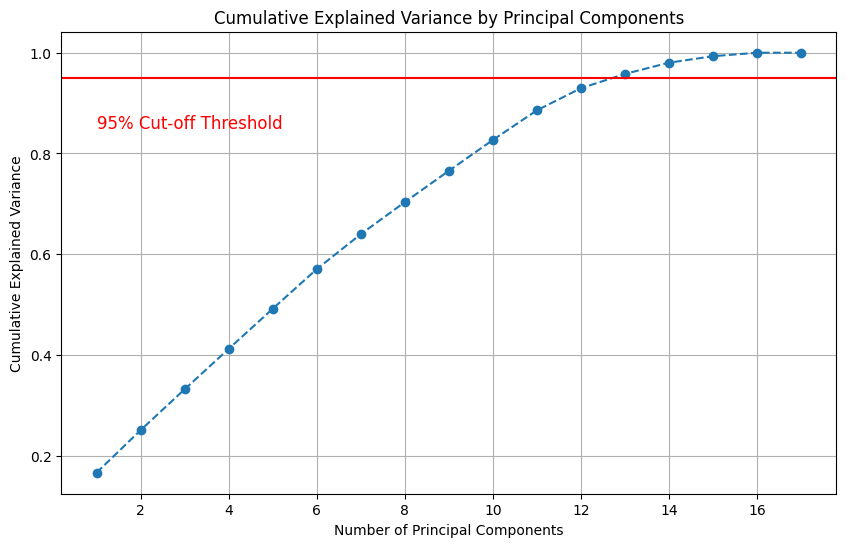

In [67]:
# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(1, 0.85, '95% Cut-off Threshold', color = 'red', fontsize=12)
plt.grid()
plt.show()

In [68]:
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining at least 95% of the variance: {n_components}")

Number of components explaining at least 95% of the variance: 13


# . Predictive Modelling

In [69]:
df.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_day', 'pickup_day_of_week', 'distance', 'Monthly_Quarter_Q2',
       'Monthly_Quarter_Q3', 'Monthly_Quarter_Q4', 'Hourly_Segments_H2',
       'Hourly_Segments_H3', 'Hourly_Segments_H4', 'Hourly_Segments_H5',
       'Hourly_Segments_H6'],
      dtype='object')

In [70]:
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
            'passenger_count', 'pickup_day', 'pickup_day_of_week', 'distance',
            'Monthly_Quarter_Q2', 'Monthly_Quarter_Q3', 'Monthly_Quarter_Q4',
            'Hourly_Segments_H2', 'Hourly_Segments_H3', 'Hourly_Segments_H4',
            'Hourly_Segments_H5', 'Hourly_Segments_H6']
x = df[feature]
y = df['fare_amount']

In [71]:
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, test_size=0.2, random_state=42)

In [72]:
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
# Standardize the data
scaler = StandardScaler()
Train_X_std = scaler.fit_transform(Train_X)
Test_X_std = scaler.transform(Test_X)

# Initialize lists to store RMSE and R-squared results
Trr = []
Tss = []
R2_train = []
R2_test = []
Adj_R2_train = []
Adj_R2_test = []

# Number of features
m = Train_X_std.shape[1]

Tss = []

for i in tqdm(range(m)):
    # Perform PCA
    pca = PCA(n_components=m - i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    
    # Calculate the total explained variance
    total_variance = np.sum(pca.explained_variance_ratio_)
    Tss.append(total_variance)

# Convert Tss to a numpy array for convenience
Tss = np.array(Tss)


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:09<00:00,  1.80it/s]


In [87]:
print("Tss:", Tss)

Tss: [1.         1.         0.99304587 0.98012219 0.95780934 0.92936138
 0.88553358 0.82658949 0.76530713 0.70306798 0.63944589 0.57004221
 0.49129201 0.41160181 0.33147768 0.25033692 0.16597521]


In [89]:
if len(Tss) == 0:
    raise ValueError("Tss is empty. Ensure Tss is populated with values before calling np.argmin.")

# Find the best number of components
best_num_components = m - np.argmin(Tss)
print(f"Best number of components: {best_num_components}")

Best number of components: 1


In [112]:
 from sklearn.preprocessing import StandardScaler, PolynomialFeatures
    # Calculate RMSE for training and test sets
n = 3  # Maximum polynomial order
orders = [f'ord-{i}' for i in range(2, n+1)]
Trd = pd.DataFrame(np.zeros((Train_X_std.shape[1], n-1)), columns=orders)
Tsd = pd.DataFrame(np.zeros((Train_X_std.shape[1], n-1)), columns=orders)

# Number of features to reduce in each iteration
m = Train_X_std.shape[1]


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [02:49<00:00,  9.97s/it]

Training RMSE (Trd):
[[2.08888176 2.03034179]
 [2.08888176 2.03034157]
 [2.0894227  2.03255532]
 [2.12261799 2.08407852]
 [2.12331955 2.08534501]
 [2.15492375 2.13131523]
 [2.15632414 2.13285058]
 [2.17115579 2.15453768]
 [2.1718517  2.15595298]
 [2.17331398 2.15741421]
 [2.18305825 2.16847915]
 [2.18630469 2.17223681]
 [2.18923466 2.17585843]
 [2.20877482 2.19968683]
 [2.22346195 2.21484077]
 [2.23557908 2.22762381]
 [2.24868958 2.24097875]]
Test RMSE (Tsd):
[[2.06467256 2.01516597]
 [2.06467255 2.01516043]
 [2.06496918 2.01584982]
 [2.09492095 2.06398543]
 [2.09500581 2.06424396]
 [2.12711465 2.10928243]
 [2.1282496  2.10985649]
 [2.14474946 2.13125677]
 [2.14539624 2.13188879]
 [2.14718547 2.1331244 ]
 [2.15695044 2.14288616]
 [2.16099951 2.14792843]
 [2.16239457 2.14896762]
 [2.18180678 2.17282462]
 [2.19640615 2.18792545]
 [2.20580813 2.19768526]
 [2.21953123 2.2117907 ]]
Best number of features: 16
Best polynomial order: 3
Best Training RMSE: 2.030341570459254
Best Test RMSE: 2.0

In [96]:
# calculating  Multiple Linear Regression(MLR)¶

In [97]:
X = sm.add_constant(X)

# Split the data into training and test sets
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, test_size=0.2, random_state=42)

# Fit the model
model = sm.OLS(Train_Y, Train_X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                 1.248e+04
Date:                Wed, 17 Jul 2024   Prob (F-statistic):               0.00
Time:                        15:38:11   Log-Likelihood:            -2.8243e+05
No. Observations:              128152   AIC:                         5.649e+05
Df Residuals:                  128135   BIC:                         5.651e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                879.2010     60

In [98]:
# Make predictions
Train_pred = model.predict(Train_X)
Test_pred = model.predict(Test_X)

In [99]:
rmse_train = np.sqrt(mean_squared_error(Train_Y, Train_pred))
rmse_test = np.sqrt(mean_squared_error(Test_Y, Test_pred))
r2_train = r2_score(Train_Y, Train_pred)
r2_test = r2_score(Test_Y, Test_pred)

In [100]:
print(f"Training RMSE: {rmse_train}")
print(f"Test RMSE: {rmse_test}")
print(f"Training R-squared: {r2_train}")
print(f"Test R-squared: {r2_test}")

Training RMSE: 2.192190743643162
Test RMSE: 2.162913432553634
Training R-squared: 0.6090657725668025
Test R-squared: 0.6175486809636019


In [101]:
# Calculate residuals
train_residuals = Train_Y - Train_pred
test_residuals = Test_Y - Test_pred

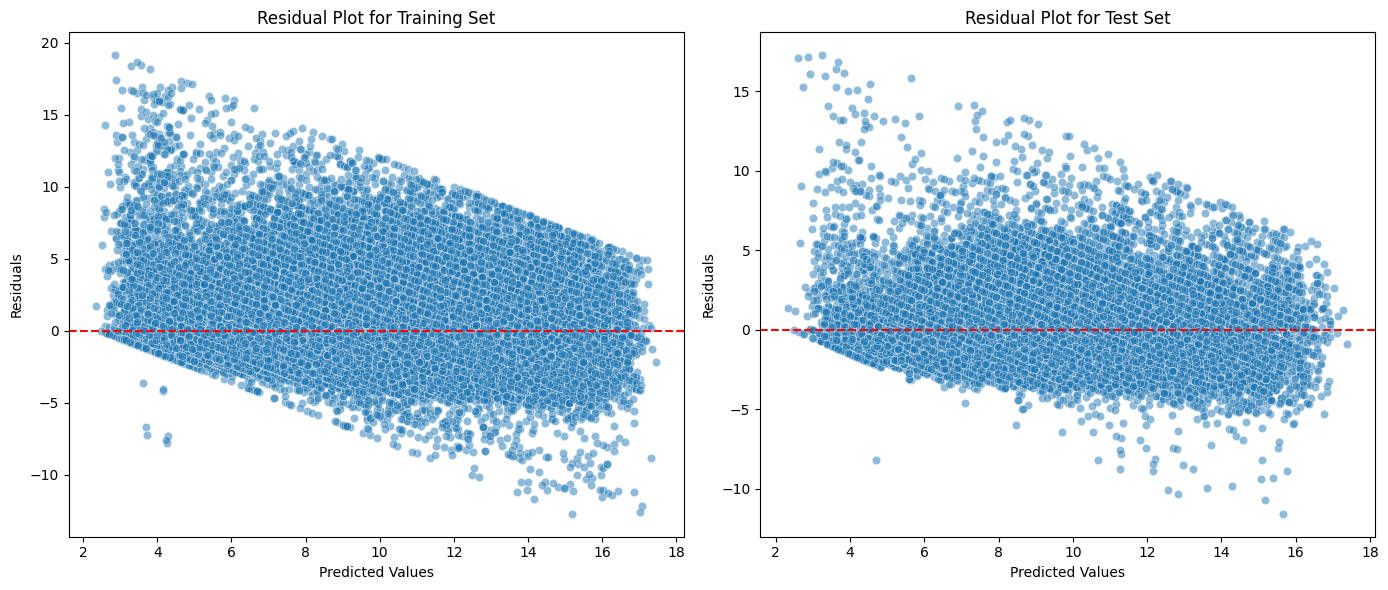

In [102]:
# Plot residuals for training and test sets
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=Train_pred, y=train_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot for Training Set')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
sns.scatterplot(x=Test_pred, y=test_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot for Test Set')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


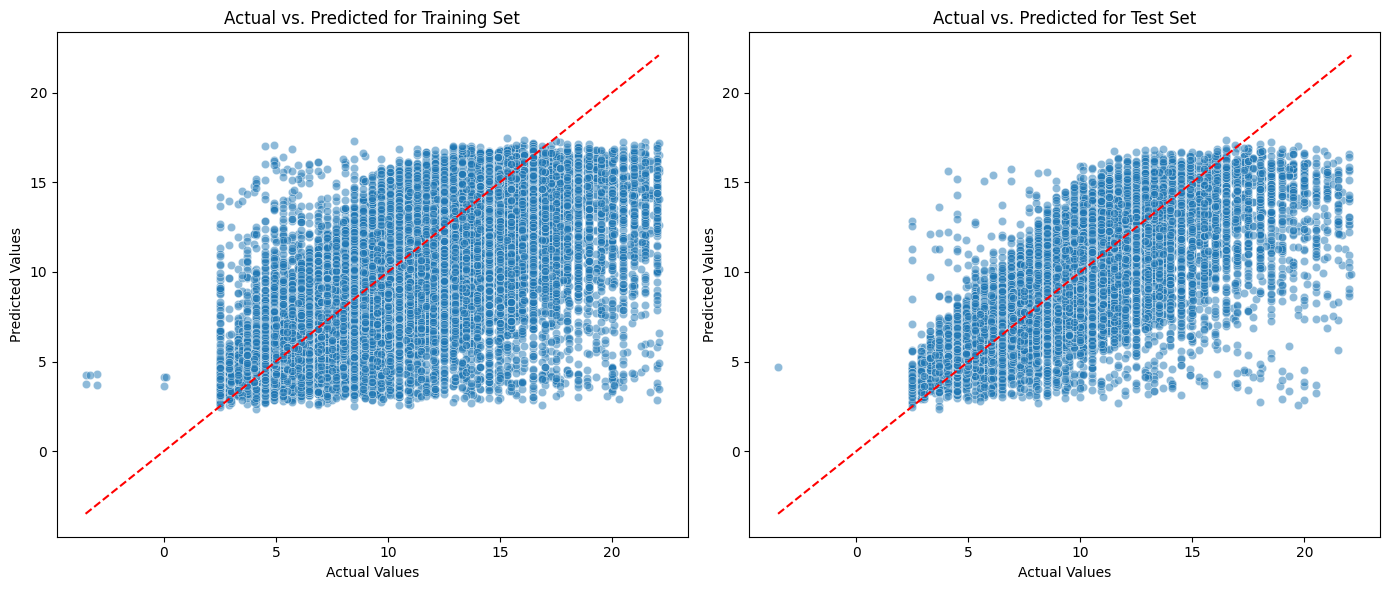

In [131]:
# Plot Actual vs. Predicted for training and test sets
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=Train_Y, y=Train_pred, alpha=0.5)
plt.plot([Train_Y.min(), Train_Y.max()], [Train_Y.min(), Train_Y.max()], 'r--')
plt.title('Actual vs. Predicted for Training Set')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.subplot(1, 2, 2)
sns.scatterplot(x=Test_Y, y=Test_pred, alpha=0.5)
plt.plot([Test_Y.min(), Test_Y.max()], [Test_Y.min(), Test_Y.max()], 'r--')
plt.title('Actual vs. Predicted for Test Set')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()

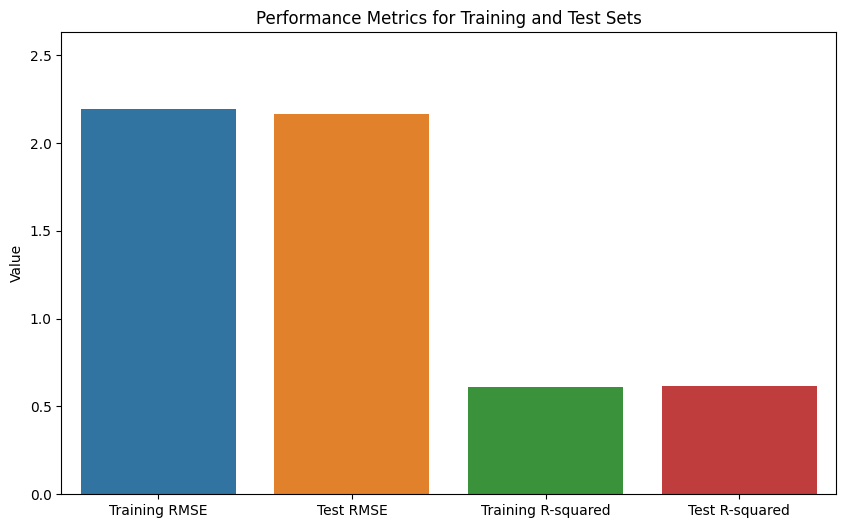

In [104]:
# Plot RMSE and R-squared for training and test sets
metrics = ['Training RMSE', 'Test RMSE', 'Training R-squared', 'Test R-squared']
values = [rmse_train, rmse_test, r2_train, r2_test]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values)
plt.title('Performance Metrics for Training and Test Sets')
plt.ylabel('Value')
plt.ylim(0, max(values) * 1.2)  # Adjust y-axis to have some space above the bars
plt.show()

In [121]:
# ridge regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

scaler = StandardScaler()
Train_X_std = pd.DataFrame(scaler.fit_transform(Train_X), columns=Train_X.columns)
Test_X_std = pd.DataFrame(scaler.transform(Test_X), columns=Test_X.columns)

# Define the Ridge Regression model
ridge = Ridge()

# Set up the hyperparameter grid
param_grid = {'alpha': np.logspace(-4, 4, 9)}  # Alpha values from 10^-4 to 10^4

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(Train_X_std, Train_Y)

# Get the best hyperparameter
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha found: {best_alpha}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best alpha found: 10.0


In [122]:
# Create a Ridge Regression model with the best alpha
best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(Train_X_std, Train_Y)

# Make predictions
pred_train = best_ridge.predict(Train_X_std)
pred_test = best_ridge.predict(Test_X_std)

In [123]:
# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(Train_Y, pred_train))
rmse_test = np.sqrt(mean_squared_error(Test_Y, pred_test))
print(f"Training RMSE: {rmse_train}")
print(f"Test RMSE: {rmse_test}")

Training RMSE: 2.192190759470729
Test RMSE: 2.1629137361162676


In [125]:
# Calculate Adjusted R and adjusted R-squared
n_train = len(Train_Y)
p_train = Train_X_std.shape[1]
adj_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)

n_test = len(Test_Y)
p_test = Test_X_std.shape[1]
adj_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

print(f"Training R-squared: {r2_train}")
print(f"Test R-squared: {r2_test}")
print(f"Training Adjusted R-squared: {adj_r2_train}")
print(f"Test Adjusted R-squared: {adj_r2_test}")

Training R-squared: 0.6090657725668025
Test R-squared: 0.6175486809636019
Training Adjusted R-squared: 0.6090139059126252
Test Adjusted R-squared: 0.617345636947999


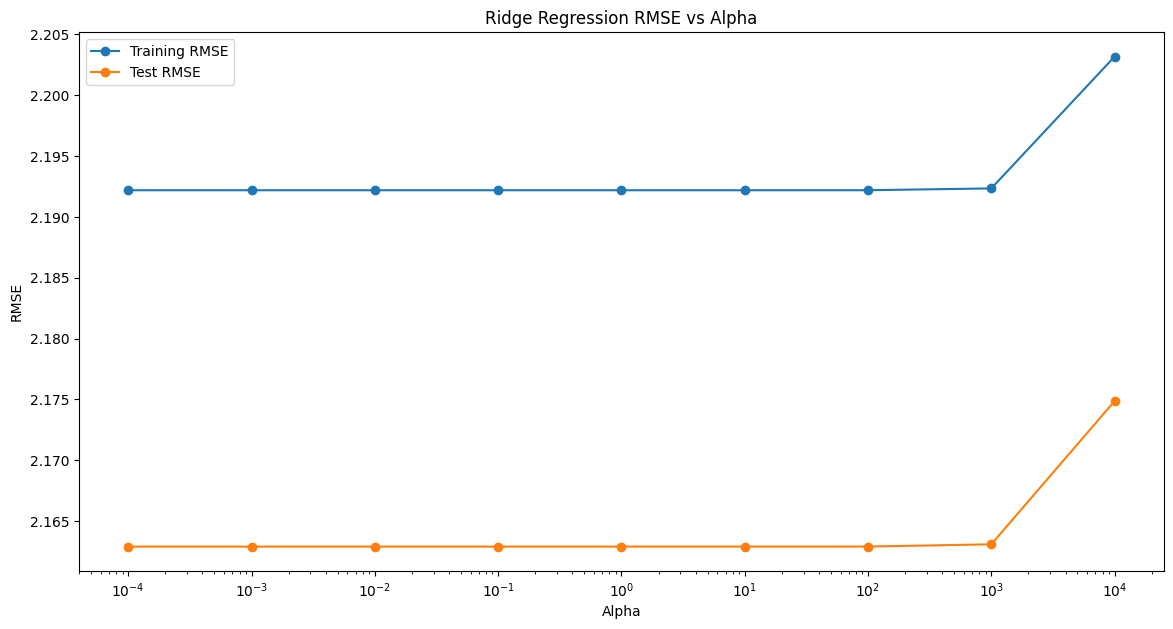

In [126]:
alphas = np.logspace(-4, 4, 9)
train_errors, test_errors = [], []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(Train_X_std, Train_Y)
    
    pred_train = ridge.predict(Train_X_std)
    pred_test = ridge.predict(Test_X_std)
    
    train_errors.append(np.sqrt(mean_squared_error(Train_Y, pred_train)))
    test_errors.append(np.sqrt(mean_squared_error(Test_Y, pred_test)))

plt.figure(figsize=[14, 7])
plt.plot(alphas, train_errors, label='Training RMSE', marker='o')
plt.plot(alphas, test_errors, label='Test RMSE', marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('Ridge Regression RMSE vs Alpha')
plt.legend()
plt.show()

In [129]:
metrics = {
    'Model': [],
    'RMSE_train': [],
    'RMSE_test': [],
    'R2_train': [],
    'R2_test': [],
    'Adj_R2_train': [],
    'Adj_R2_test': []
}

# Define and train Linear Regression
lm = LinearRegression()
lm.fit(Train_X_std, Train_Y)

# Make predictions
pred_train_lm = lm.predict(Train_X_std)
pred_test_lm = lm.predict(Test_X_std)

In [132]:
# Calculate metrics for Linear Regression
rmse_train_lm = np.sqrt(mean_squared_error(Train_Y, pred_train_lm))
rmse_test_lm = np.sqrt(mean_squared_error(Test_Y, pred_test_lm))
r2_train_lm = r2_score(Train_Y, pred_train_lm)
r2_test_lm = r2_score(Test_Y, pred_test_lm)
adj_r2_train_lm = 1 - (1 - r2_train_lm) * (len(Train_Y) - 1) / (len(Train_Y) - Train_X_std.shape[1] - 1)
adj_r2_test_lm = 1 - (1 - r2_test_lm) * (len(Test_Y) - 1) / (len(Test_Y) - Test_X_std.shape[1] - 1)

metrics['Model'].append('Linear Regression')
metrics['RMSE_train'].append(rmse_train_lm)
metrics['RMSE_test'].append(rmse_test_lm)
metrics['R2_train'].append(r2_train_lm)
metrics['R2_test'].append(r2_test_lm)
metrics['Adj_R2_train'].append(adj_r2_train_lm)
metrics['Adj_R2_test'].append(adj_r2_test_lm)

In [133]:
#Train Polynomial Ridge Regression Model
for i in tqdm(range(m)):
    ridge = Ridge(alpha=best_alpha)
    
    # Perform RFE
    rfe = RFE(ridge, n_features_to_select=m - i)
    rfe.fit(Train_X_std, Train_Y)
    
    selected_features = Train_X_std.loc[:, rfe.support_]
    test_selected_features = Test_X_std.loc[:, rfe.support_]
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=2)  # Change degree as needed
    Train_X_poly = poly.fit_transform(selected_features)
    Test_X_poly = poly.transform(test_selected_features)
    
    # Fit Ridge model with selected features and polynomial features
    ridge.fit(Train_X_poly, Train_Y)
    
    # Make predictions
    pred_train_poly = ridge.predict(Train_X_poly)
    pred_test_poly = ridge.predict(Test_X_poly)
    
    # Calculate metrics for Polynomial Ridge Regression
    rmse_train_poly = np.sqrt(mean_squared_error(Train_Y, pred_train_poly))
    rmse_test_poly = np.sqrt(mean_squared_error(Test_Y, pred_test_poly))
    r2_train_poly = r2_score(Train_Y, pred_train_poly)
    r2_test_poly = r2_score(Test_Y, pred_test_poly)
    adj_r2_train_poly = 1 - (1 - r2_train_poly) * (len(Train_Y) - 1) / (len(Train_Y) - Train_X_poly.shape[1] - 1)
    adj_r2_test_poly = 1 - (1 - r2_test_poly) * (len(Test_Y) - 1) / (len(Test_Y) - Test_X_poly.shape[1] - 1)
    
    # Append metrics for the current iteration
    metrics['Model'].append(f'Poly Ridge Regression (Features: {m - i})')
    metrics['RMSE_train'].append(rmse_train_poly)
    metrics['RMSE_test'].append(rmse_test_poly)
    metrics['R2_train'].append(r2_train_poly)
    metrics['R2_test'].append(r2_test_poly)
    metrics['Adj_R2_train'].append(adj_r2_train_poly)
    metrics['Adj_R2_test'].append(adj_r2_test_poly)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:12<00:00,  1.37it/s]


In [135]:
#Convert Metrics to a DataFrame and Display
metrics_df = pd.DataFrame(metrics)

# Print the DataFrame
print(metrics_df)
# Optionally, you can save the metrics to a CSV file for further analysis
metrics_df.to_csv('model_comparison_metrics.csv', index=False)


                                   Model  RMSE_train  RMSE_test  R2_train  \
0                      Linear Regression    2.192191   2.162913  0.609066   
1                      Linear Regression    2.192191   2.162913  0.609066   
2   Poly Ridge Regression (Features: 17)    2.090981   2.067514  0.644330   
3   Poly Ridge Regression (Features: 16)    2.090981   2.067514  0.644330   
4   Poly Ridge Regression (Features: 15)    2.091511   2.067804  0.644150   
5   Poly Ridge Regression (Features: 14)    2.122619   2.094936  0.633486   
6   Poly Ridge Regression (Features: 13)    2.123320   2.095021  0.633243   
7   Poly Ridge Regression (Features: 12)    2.154924   2.127115  0.622244   
8   Poly Ridge Regression (Features: 11)    2.156324   2.128251  0.621753   
9   Poly Ridge Regression (Features: 10)    2.171156   2.144750  0.616532   
10   Poly Ridge Regression (Features: 9)    2.171851   2.145398  0.616287   
11   Poly Ridge Regression (Features: 8)    2.173307   2.147138  0.615772   

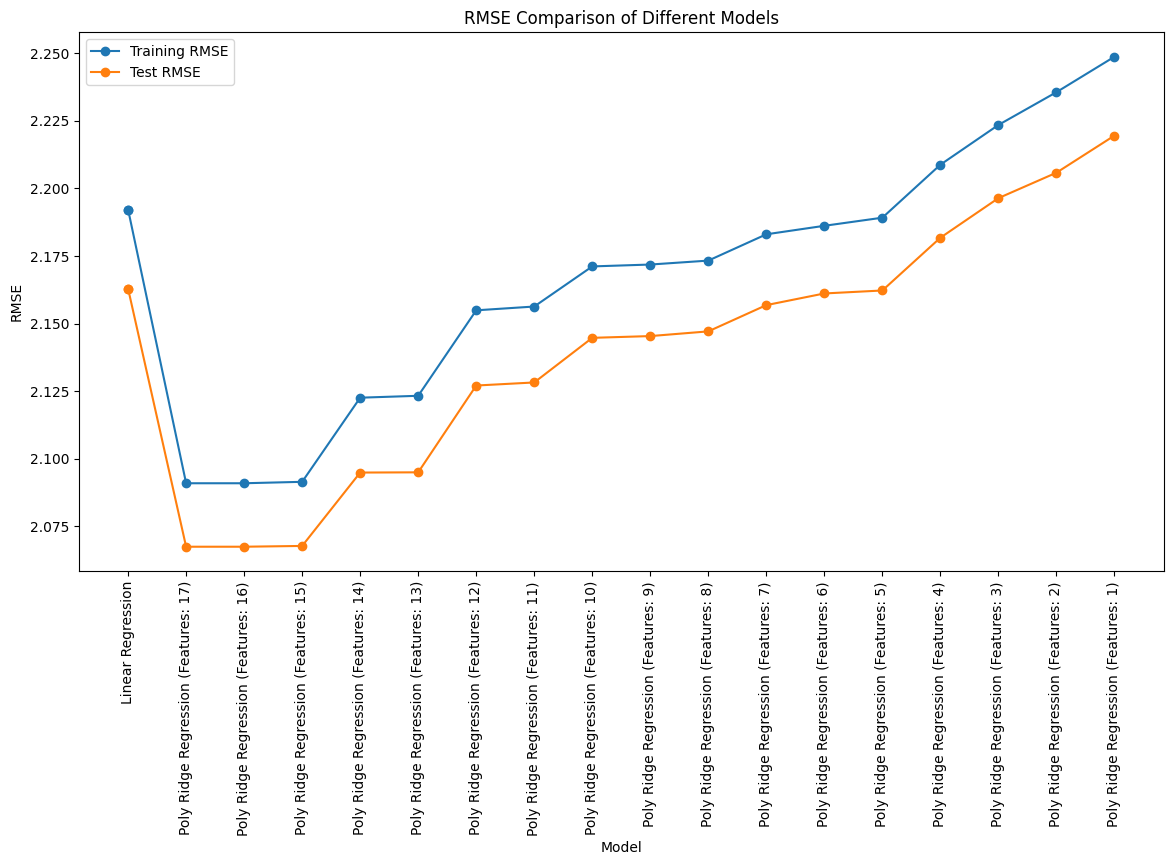

In [136]:
# Plotting RMSE for different models
plt.figure(figsize=[14, 7])
plt.plot(metrics_df['Model'], metrics_df['RMSE_train'], label='Training RMSE', marker='o')
plt.plot(metrics_df['Model'], metrics_df['RMSE_test'], label='Test RMSE', marker='o')
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Comparison of Different Models')
plt.legend()
plt.show()

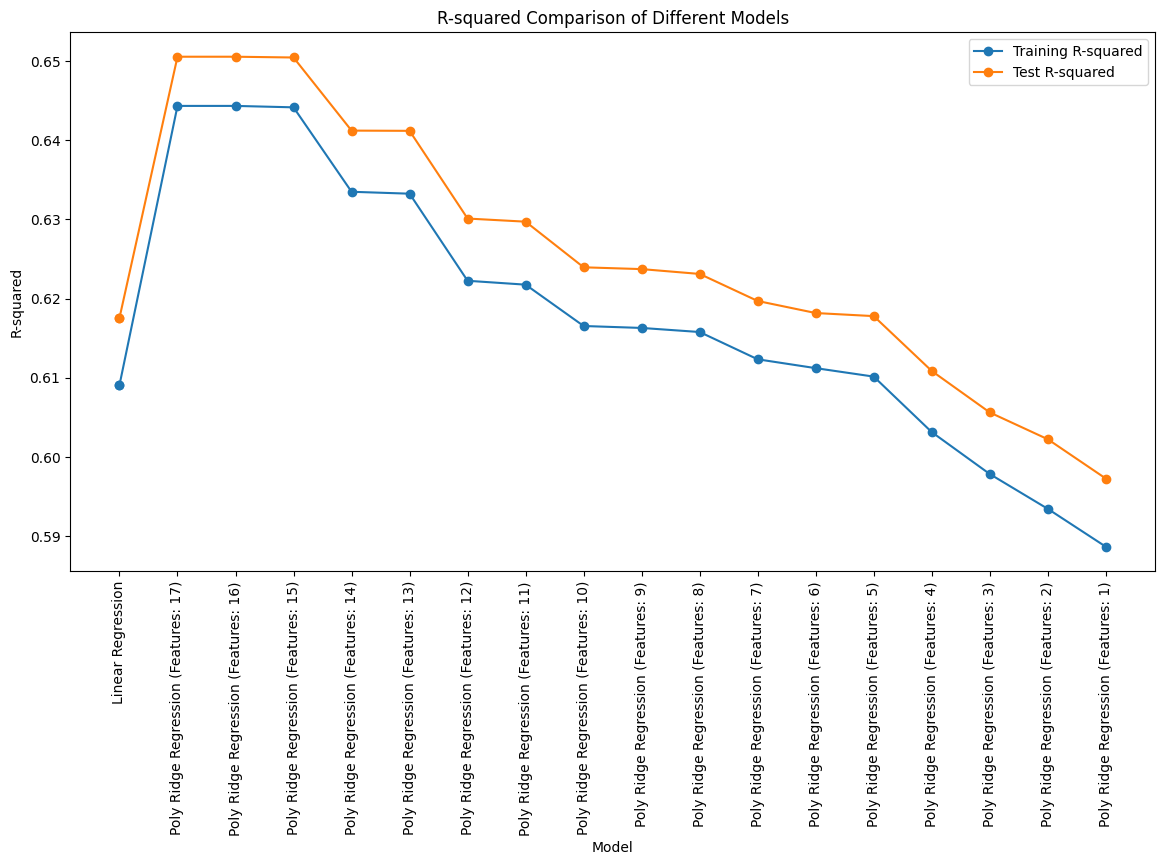

In [137]:
# Plotting R-squared for different models
plt.figure(figsize=[14, 7])
plt.plot(metrics_df['Model'], metrics_df['R2_train'], label='Training R-squared', marker='o')
plt.plot(metrics_df['Model'], metrics_df['R2_test'], label='Test R-squared', marker='o')
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.ylabel('R-squared')
plt.title('R-squared Comparison of Different Models')
plt.legend()
plt.show()

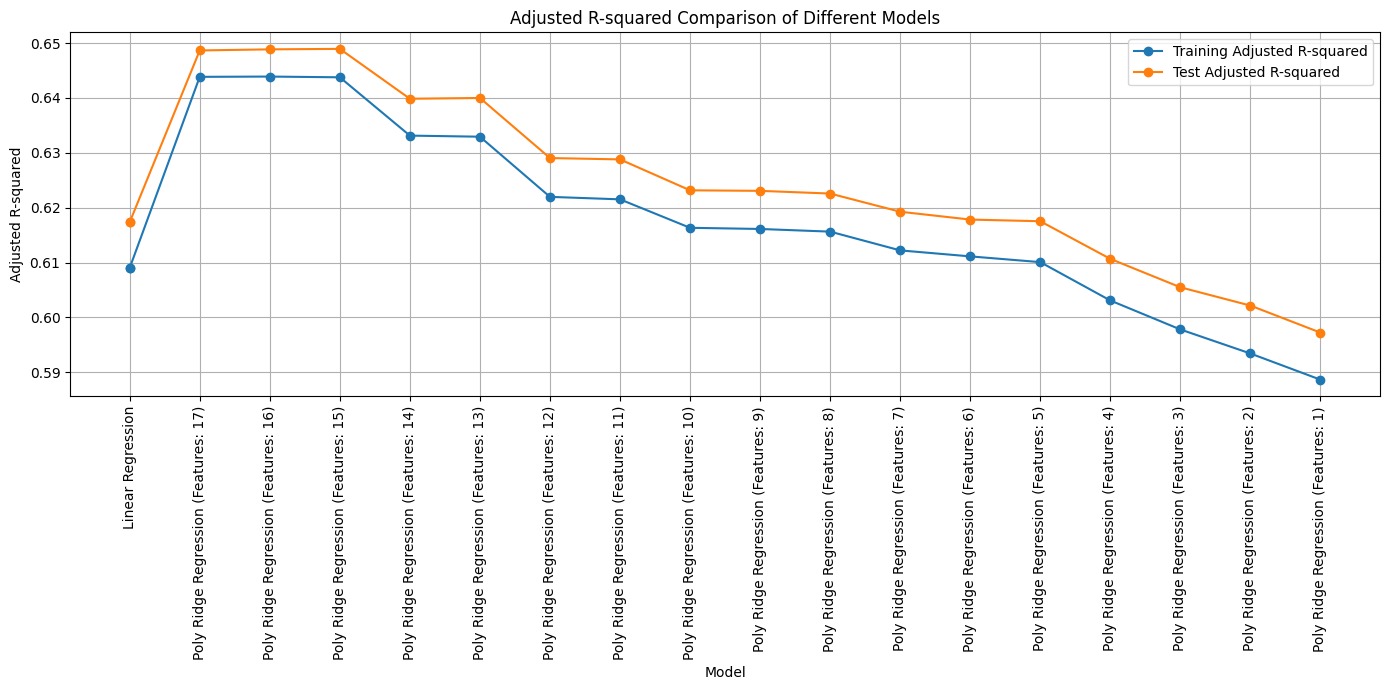

In [142]:
# Plotting Adjusted R-squared for different models
plt.figure(figsize=[14, 7])
plt.plot(metrics_df['Model'], metrics_df['Adj_R2_train'], label='Training Adjusted R-squared', marker='o')
plt.plot(metrics_df['Model'], metrics_df['Adj_R2_test'], label='Test Adjusted R-squared', marker='o')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Model')
plt.ylabel('Adjusted R-squared')
plt.title('Adjusted R-squared Comparison of Different Models')
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()
